In [71]:
import torch

# n_bits = 8
# vec = torch.randn(10,15)
# frob_norm = False

def qsgd(vec, n_bits=2, frob_norm=False):
    """
    Implementation of random compresson using QSGD. 
    Ref -> Alistarh, Dan, et al. "QSGD: Communication-efficient SGD via gradient quantization and encoding." Advances in Neural Information Processing Systems 30 (2017): 1709-1720.
    
    Original implementation used frobenius norm. Here we found that max norm is better in for GCCA case.
    """
    if vec.is_cuda:
        vec = vec.to('cpu')
    s = 2**(n_bits-1) - 1
    abs_vec = torch.abs(vec)
    if frob_norm:
        norm = torch.norm(vec, 'fro')
    else:
        norm = torch.max(torch.abs(vec))
    normalized_vec = abs_vec/norm
    scaled_vec = normalized_vec * s
    l = torch.floor(scaled_vec)
    prob = scaled_vec - l

    # l[i] <- l[i] + 1 with probability |v_i| / ||v|| * s - l
    probabilities = scaled_vec - l
    r = torch.rand(l.size())
    l += (probabilities > r)
    signs = torch.sign(vec)

    signed_l = l*signs
    quantized = signed_l*norm/s
    return quantized

## Testing for file

In [1]:
from collections import OrderedDict, namedtuple
from itertools import product
import argparse
from tqdm import tqdm, trange
from IPython.display import clear_output
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, DeepGCCA
from utils.synth_data_toy_2d import create_synthData
import pprint as pp
from utils.qsgd import qsgd

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']

parser = argparse.ArgumentParser(description="Toy 2d DGCCA")

# Data
parser.add_argument('--model_dest', default='trained_models/dgcca_toy_rand_2d1_centered.model', help="Destination model path")
parser.add_argument('--random_seed', default=23423, help='')

args = vars(parser.parse_args(args = []))
pp.pprint(args)

# Set the random seed
torch.manual_seed(int(args['random_seed']))

params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    inner_epochs = [50],
    quant = [True], 
    rand_compress=[True], 
    n_bits=[3]
)

layer_sizes_list = 3*[[128, 64, 2]]
input_size_list = 3*[2]

run_count = 0
models = []

run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
  
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = DeepGCCA(layer_sizes_list, input_size_list)
    dgcca = dgcca.to(device)
    
    train_views, classes = create_synthData(N=10000)
    val_views, classes = create_synthData(N=200)
    suffler = torch.randperm(10000)
    
    train_views = [view[suffler].to(device) for view in train_views]
    val_views = [view.to(device) for view in val_views]
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()
    num_val_batches = len(val_views[0])//run.batch_size
    
    # init G
    dgcca.eval()
    out = dgcca(train_views)
    out = torch.stack(out)  
    G = g_step(out.clone().detach())  
    M_serv = out.clone()
    M_diff = out.clone()
    dgcca.train()
    
    for epoch in trange(50):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        for j in range(run.inner_epochs):
            for i in range(num_batches):
                optimizer.zero_grad()
                batch = []
                
                # SGD
                batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :] for view in train_views]            
                target = G[(i*run.batch_size):((i+1)*run.batch_size), :]

                # full gradient
                # batch = train_views
                # target = G

                out = dgcca(batch)
                out = torch.stack(out)  
                
                loss = 1/2*torch.norm(out-target)/target.shape[0]
                
                loss.backward()
                optimizer.step()
                
                total_recons_loss += loss.item()
                
        ## Update G
        dgcca.eval()
        out = dgcca(train_views)
        out = torch.stack(out)
        
        if run.quant:
            for i in range(len(train_views)):
                M_diff[i] = out[i] - M_serv[i]
                max_val = M_diff[i].abs().max()
                
                if run.rand_compress:
                    M_quant = qsgd(M_diff[i], n_bits=run.n_bits).to(device)
                else:
                    M_quant = ((1/max_val)*M_diff[i]).round()*(max_val/1)
                    
                M_serv[i] += M_quant
                M_serv[i] -= M_serv[i].mean(dim=0)
            G = g_step(M_serv.clone().detach())          
        else:
            G = g_step(out.clone().detach())  
            
        
        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        G_val = g_step(out_val.clone().detach())
        loss_val = 1/2*torch.norm(out_val - G_val)/G_val.shape[0]
        total_val_loss = loss_val.item()
        del out_val, out, G_val
        dgcca.train()
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/(num_batches*run.inner_epochs)
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        # df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        # clear_output(wait=True)
        # show_latent()
        # display(df2)

        torch.save(dgcca, args['model_dest'])

{'model_dest': 'trained_models/dgcca_toy_rand_2d1_centered.model',
 'random_seed': 23423}


100%|██████████| 50/50 [03:52<00:00,  4.64s/it]


In [84]:
M_serv.shape

torch.Size([3, 10000, 2])

In [90]:
M_serv.mean(dim=1)

tensor([[-1.6607e-03, -1.0152e-02],
        [-6.0744e-05, -1.0051e-02],
        [-1.6004e-03, -9.8318e-03]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [4]:
args['model_dest']

'trained_models/dgcca_toy_2d1.model'

In [10]:
def plot_latent(dgcca_vanilla_path = 'trained_models/dgcca1.model', dgcca_fed_path='trained_models/dgcca_federated1.model', device='cuda'):
    dgcca_vanilla = torch.load(dgcca_vanilla_path)
    dgcca_fed = torch.load(dgcca_fed_path)

    train_views, classes = create_synthData(N=1000)
    val_views, classes = create_synthData(N=200)

    train_views = [view.to(device) for view in train_views]
    val_views = [view.to(device) for view in val_views]

    out1 = dgcca_vanilla(train_views)
    out1 = [a.to('cpu').detach() for a in out1]


    out1 = dgcca_vanilla(train_views)
    G1 = g_step(torch.stack(out1).clone().detach())
    out1 = [a.to('cpu').detach() for a in out1]

    out2 = dgcca_fed(train_views)
    G2 = g_step(torch.stack(out2).clone().detach())
    out2 = [a.to('cpu').detach() for a in out2]

    G1 = G1.detach().to('cpu')
    G2 = G2.detach().to('cpu')

    target = [t.to('cpu').detach() for t in train_views]

    fig, axes = plt.subplots(4,3, figsize=(10,10))

    axes[0,0].set_title('Data')
    axes[0,0].scatter(target[0][:,0], target[0][:,1], c=500*[1]+500*[2])
    axes[0,0].set_ylabel('View1')
    axes[1,0].scatter(target[1][:,0], target[1][:,1], c=500*[1]+500*[2])
    axes[1,0].set_ylabel('View2')
    axes[2,0].scatter(target[2][:,0], target[2][:,1], c=500*[1]+500*[2])
    axes[2,0].set_ylabel('View3')
    axes[3,0].set_ylabel('Latent Representation (G)')

    axes[0,1].set_title("Vanilla DGCCA")
    axes[0,1].scatter(out1[0][:,0], out1[0][:,1], c=500*[1]+500*[2])
    axes[1,1].scatter(out1[1][:,0], out1[1][:,1], c=500*[1]+500*[2])
    axes[2,1].scatter(out1[2][:,0], out1[2][:,1], c=500*[1]+500*[2])
    axes[3,1].scatter(G1[:,0], G1[:,1], c=500*[1]+500*[2])

    axes[0,2].set_title("Federated DGCCA, 2 bits per scalar")
    axes[0,2].scatter(out2[0][:,0], out2[0][:,1], c=500*[1]+500*[2])
    axes[1,2].scatter(out2[1][:,0], out2[1][:,1], c=500*[1]+500*[2])
    axes[2,2].scatter(out2[2][:,0], out2[2][:,1], c=500*[1]+500*[2])
    axes[3,2].scatter(G2[:,0], G2[:,1], c=500*[1]+500*[2])

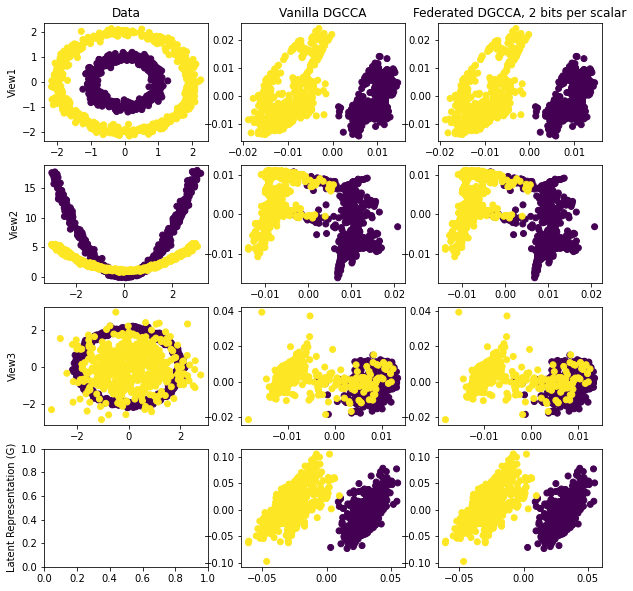

In [3]:
from utils.eval_toy_2d import plot_latent

plot_latent(dgcca_vanilla_path=args['model_dest'], dgcca_fed_path = args['model_dest'])

## Plots

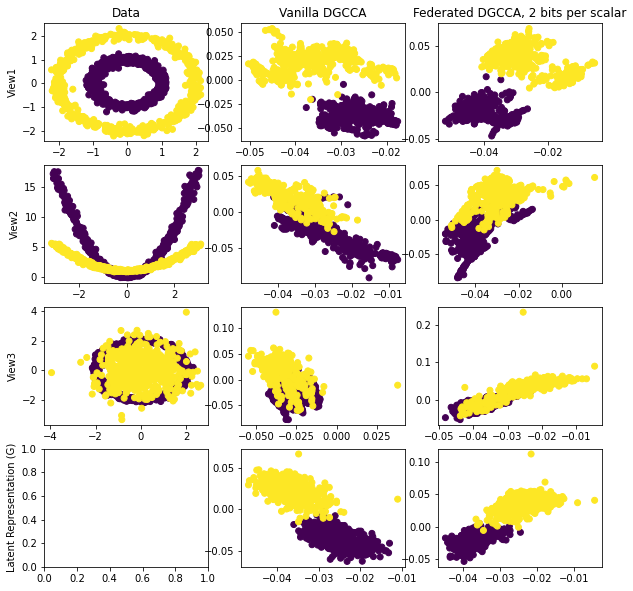

In [34]:
dgcca_vanilla = torch.load('trained_models/dgcca1.model')
dgcca_fed = torch.load('trained_models/dgcca_federated1.model')

train_views, classes = create_synthData(N=1000)
val_views, classes = create_synthData(N=200)

train_views = [view.to(device) for view in train_views]
val_views = [view.to(device) for view in val_views]

out1 = dgcca_vanilla(train_views)
out1 = [a.to('cpu').detach() for a in out1]


out1 = dgcca_vanilla(train_views)
G1 = g_step(torch.stack(out1).clone().detach())
out1 = [a.to('cpu').detach() for a in out1]

out2 = dgcca_fed(train_views)
G2 = g_step(torch.stack(out2).clone().detach())
out2 = [a.to('cpu').detach() for a in out2]

G1 = G1.detach().to('cpu')
G2 = G2.detach().to('cpu')

target = [t.to('cpu').detach() for t in train_views]

fig, axes = plt.subplots(4,3, figsize=(10,10))

axes[0,0].set_title('Data')
axes[0,0].scatter(target[0][:,0], target[0][:,1], c=500*[1]+500*[2])
axes[0,0].set_ylabel('View1')
axes[1,0].scatter(target[1][:,0], target[1][:,1], c=500*[1]+500*[2])
axes[1,0].set_ylabel('View2')
axes[2,0].scatter(target[2][:,0], target[2][:,1], c=500*[1]+500*[2])
axes[2,0].set_ylabel('View3')
axes[3,0].set_ylabel('Latent Representation (G)')

axes[0,1].set_title("Vanilla DGCCA")
axes[0,1].scatter(out1[0][:,0], out1[0][:,1], c=500*[1]+500*[2])
axes[1,1].scatter(out1[1][:,0], out1[1][:,1], c=500*[1]+500*[2])
axes[2,1].scatter(out1[2][:,0], out1[2][:,1], c=500*[1]+500*[2])
axes[3,1].scatter(G1[:,0], G1[:,1], c=500*[1]+500*[2])

axes[0,2].set_title("Federated DGCCA, 2 bits per scalar")
axes[0,2].scatter(out2[0][:,0], out2[0][:,1], c=500*[1]+500*[2])
axes[1,2].scatter(out2[1][:,0], out2[1][:,1], c=500*[1]+500*[2])
axes[2,2].scatter(out2[2][:,0], out2[2][:,1], c=500*[1]+500*[2])
axes[3,2].scatter(G2[:,0], G2[:,1], c=500*[1]+500*[2])


In [5]:
from collections import OrderedDict, namedtuple
from itertools import product
import argparse
from tqdm import tqdm, trange
from IPython.display import clear_output
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from dgcca.utils.run_manager import RunBuilder
from dgcca.utils.compressor import qsgd
from dgcca.models import g_step, DeepGCCA
from dgcca.toy_2d.synth_data_toy_2d import create_synthData
import pprint as pp
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

parser = argparse.ArgumentParser(description="Toy 2d DGCCA")

# Data
parser.add_argument('--model_dest', default='../trained_models/dgcca_toy_altmaxvar1.model', help="Destination model path")
parser.add_argument('--random_seed', default=5555, help='')
parser.add_argument('--compress', default=False, help='')
parser.add_argument('--compression_scheme', default='qsgd', help='')
parser.add_argument('--compress_downlink', default=True, help='')
parser.add_argument('--batch_size', default=1000, help='')
parser.add_argument('--lr', default=0.001, help='')
parser.add_argument('--device', default='cpu', help='')
parser.add_argument('--inner_epochs', default=7, help='')
parser.add_argument('--shuffle', default=True, help='')
parser.add_argument('--nbits', default=3, help='')
parser.add_argument('--num_epochs', default=50, help='')

args = vars(parser.parse_args([]))
pp.pprint(args)

# Set the random seed
torch.manual_seed(int(args['random_seed']))

# some special parameters
layer_sizes_list = 3*[[128, 64, 2]]
input_size_list = 3*[2]
num_workers = 5
loss_func = nn.MSELoss

data_load_time = 0
forward_time = 0
run_data = []

device = torch.device(args['device'])

# eval and train models and copy the train params to eval
dgcca_train = DeepGCCA(layer_sizes_list, input_size_list)
dgcca_train = dgcca_train.to(device)
dgcca_eval = DeepGCCA(layer_sizes_list, input_size_list)
dgcca_eval.load_state_dict(dgcca_train.state_dict())

# Get train and validation dataset
train_views, train_classes = create_synthData(N=10000)
val_views, val_classes = create_synthData(N=2000)
# shuffle the dataset
suffler = torch.randperm(10000)
train_views = [view[suffler].to(device) for view in train_views]

val_shuffler = torch.randperm(2000)
val_views = [view[val_shuffler].to(device) for view in val_views]
val_classes = [classes[val_shuffler] for classes in val_classes]

optimizer = torch.optim.Adam(dgcca_train.parameters(), lr=args['lr'])
num_batches = len(train_views[0])//args['batch_size']

criterion = loss_func()
num_val_batches = len(val_views[0])//args['batch_size']

# init G
dgcca_eval.eval()
M_client = torch.stack(dgcca_eval(train_views))
G_server = g_step(M_client.clone().detach())  

M_serv = M_client.clone()
G_client = G_server.clone()

dgcca_train.train()

for epoch in range(args['num_epochs']):
    total_dgcca_loss = 0
    total_val_loss = 0
    batch_count = 0

    for j in range(args['inner_epochs']):
        for i in range(num_batches):
            optimizer.zero_grad()
            batch = []

            # SGD
            batch = [view[(i*args['batch_size']):((i+1)*args['batch_size']), :] for view in train_views]            
            target = G_client[(i*args['batch_size']):((i+1)*args['batch_size']), :]

            # full gradient
            # batch = train_views
            # target = G

            out = torch.stack(dgcca_train(batch))  

            loss = 1/2*torch.norm(out-target)/target.shape[0]

            loss.backward()
            optimizer.step()

            total_dgcca_loss += loss.item()

    ## Update G
    dgcca_eval.load_state_dict(dgcca_train.state_dict())
    M_client = dgcca_eval(train_views)
    M_client = torch.stack(M_client)

    if args['compress']:
        for i in range(len(train_views)):
            diff = M_client[i] - M_serv[i]
            max_val = diff.abs().max()
            if args['compression_scheme'] == 'qsgd':
                quant = qsgd(diff, n_bits=args['nbits'])
            else:
                quant = ((1/max_val)*diff).round()*(max_val/1)    
            M_serv[i] = M_serv[i] + quant
            M_serv[i] -= M_serv[i].mean(dim=0)
            del max_val, diff, quant
            G_serv = g_step(M_serv.clone().detach())
        
        if args['compress_downlink']:
            if args['compression_scheme'] == 'qsgd':
                G_client = G_client + qsgd(G_serv-G_client, n_bits=args['nbits'])
            else:
                # TODO: implement compression inside functions
                G_client = G_serv.clone()
        else:
            G_client = G_serv.clone()
    else:
        M_client = M_client - M_client.mean(dim=1).unsqueeze(dim=1)
        M_serv = M_client.clone()
        G_serv = g_step(M_serv.clone().detach())  
        G_client = G_serv.clone() 
    del M_client

    # validation loss
    out_val = torch.stack(dgcca_eval(val_views))
    G_val = g_step(out_val.clone().detach())
    loss_val = 1/2*torch.norm(out_val-G_val)/G_val.shape[0]
    total_val_loss = loss_val.item()

    clf = svm.LinearSVC()
    clf.fit(G_val[:-1000,:].numpy(), val_classes[0][:-1000].numpy())

    results = OrderedDict()
    results['epoch'] = epoch
    results['data_fidelity'] = total_dgcca_loss/(num_batches*args['inner_epochs'])
    results['val_fidelity'] = total_val_loss
    results['batch_size'] = args['batch_size']
    results['class_acc'] = accuracy_score(val_classes[0][-1000:].numpy(), clf.predict(G_val[-1000:,:]))
    results['lr'] = args['lr']
    results['device'] = args['device']
    
    run_data.append(results)
    df_alt = pd.DataFrame.from_dict(run_data, orient='columns')
    clear_output(wait=True)
    display(df_alt)

    torch.save(dgcca_train, args['model_dest'])

,epoch,data_fidelity,val_fidelity,batch_size,class_acc,lr,device
0,0,0.002025,0.000514,1000,0.635,0.001,cpu


KeyboardInterrupt: 

In [1]:
from collections import OrderedDict, namedtuple
from itertools import product
import argparse
from tqdm import tqdm, trange
from IPython.display import clear_output
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from dgcca.utils.run_manager import RunBuilder
from dgcca.utils.compressor import qsgd
from dgcca.models import g_step, DeepGCCA
from dgcca.toy_2d.synth_data_toy_2d import create_synthData
import pprint as pp
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import pickle

parser = argparse.ArgumentParser(description="Toy 2d DGCCA")

# Data
parser.add_argument('--model_dest', default='../trained_models/dgcca_toy_altmaxvar.model', help="Destination model path")
parser.add_argument('--random_seed', default=5555, help='')
parser.add_argument('--compress', default=False, help='')
parser.add_argument('--compression_scheme', default='qsgd', help='')
parser.add_argument('--compress_downlink', default=True, help='')
parser.add_argument('--batch_size', default=1000, help='')
parser.add_argument('--lr', default=0.001, help='')
parser.add_argument('--device', default='cpu', help='')
parser.add_argument('--inner_epochs', default=7, help='')
parser.add_argument('--shuffle', default=True, help='')
parser.add_argument('--nbits', default=3, help='')
parser.add_argument('--num_epochs', default=50, help='')
parser.add_argument('--n_trials', default=10, help='')

args = vars(parser.parse_args([]))
pp.pprint(args)

# Set the random seed
torch.manual_seed(int(args['random_seed']))

# some special parameters
layer_sizes_list = 3*[[128, 64, 2]]
input_size_list = 3*[2]
num_workers = 5
loss_func = nn.MSELoss

data_load_time = 0
forward_time = 0

device = torch.device(args['device'])

# acc_alt = np.zeros((args['n_trials'], args['num_epochs']))
acc = pickle.load(open('../plt/acc_cute_toy.pkl', 'rb'))
for trial_id in range(args['n_trials']-4):
    run_data = []
    
    # eval and train models and copy the train params to eval
    dgcca_train = DeepGCCA(layer_sizes_list, input_size_list)
    dgcca_train = dgcca_train.to(device)
    dgcca_eval = DeepGCCA(layer_sizes_list, input_size_list)
    dgcca_eval.load_state_dict(dgcca_train.state_dict())

    # Get train and validation dataset
    train_views, train_classes = create_synthData(N=10000)
    val_views, val_classes = create_synthData(N=2000)
    # shuffle the dataset
    suffler = torch.randperm(10000)
    train_views = [view[suffler].to(device) for view in train_views]

    val_shuffler = torch.randperm(2000)
    val_views = [view[val_shuffler].to(device) for view in val_views]
    val_classes = [classes[val_shuffler] for classes in val_classes]

    optimizer = torch.optim.Adam(dgcca_train.parameters(), lr=args['lr'])
    num_batches = len(train_views[0])//args['batch_size']

    criterion = loss_func()
    num_val_batches = len(val_views[0])//args['batch_size']

    # init G
    dgcca_eval.eval()
    M_client = torch.stack(dgcca_eval(train_views))
    G_server = g_step(M_client.clone().detach())  

    M_serv = M_client.clone()
    G_client = G_server.clone()

    dgcca_train.train()

    for epoch in range(args['num_epochs']):
        total_dgcca_loss = 0
        total_val_loss = 0
        batch_count = 0

        for j in range(args['inner_epochs']):
            for i in range(num_batches):
                optimizer.zero_grad()
                batch = []

                # SGD

                batch = [view[(i*args['batch_size']):((i+1)*args['batch_size']), :] for view in train_views]            
                target = G_client[(i*args['batch_size']):((i+1)*args['batch_size']), :]

                # full gradient
                # batch = train_views
                # target = G

                out = torch.stack(dgcca_train(batch))  

                loss = 1/2*torch.norm(out-target)/target.shape[0]

                loss.backward()
                optimizer.step()

                total_dgcca_loss += loss.item()

        ## Update G
        dgcca_eval.load_state_dict(dgcca_train.state_dict())
        M_client = dgcca_eval(train_views)
        M_client = torch.stack(M_client)

        if args['compress']:
            for i in range(len(train_views)):
                diff = M_client[i] - M_serv[i]
                max_val = diff.abs().max()
                if args['compression_scheme'] == 'qsgd':
                    quant = qsgd(diff, n_bits=args['nbits'])
                else:
                    quant = ((1/max_val)*diff).round()*(max_val/1)    
                M_serv[i] = M_serv[i] + quant
                M_serv[i] -= M_serv[i].mean(dim=0)
                del max_val, diff, quant
                G_serv = g_step(M_serv.clone().detach())

            if args['compress_downlink']:
                if args['compression_scheme'] == 'qsgd':
                    G_client = G_client + qsgd(G_serv-G_client, n_bits=args['nbits'])
                else:
                    # TODO: implement compression inside functions
                    G_client = G_serv.clone()
            else:
                G_client = G_serv.clone()
        else:
            M_client = M_client - M_client.mean(dim=1).unsqueeze(dim=1)
            M_serv = M_client.clone()
            G_serv = g_step(M_serv.clone().detach())  
            G_client = G_serv.clone() 
        del M_client

        # validation loss
        out_val = torch.stack(dgcca_eval(val_views))
        G_val = g_step(out_val.clone().detach())
        loss_val = 1/2*torch.norm(out_val-G_val)/G_val.shape[0]
        total_val_loss = loss_val.item()

        clf = svm.LinearSVC()
        clf.fit(G_val[:-1000,:].numpy(), val_classes[0][:-1000].numpy())

        results = OrderedDict()
        results['epoch'] = epoch
        results['data_fidelity'] = total_dgcca_loss/(num_batches*args['inner_epochs'])
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = args['batch_size']
        results['class_acc'] = accuracy_score(val_classes[0][-1000:].numpy(), clf.predict(G_val[-1000:,:]))
        results['lr'] = args['lr']
        results['device'] = args['device']
        
        acc['alt'][trial_id+4, epoch] = results['class_acc']
        
        run_data.append(results)
        df_cute = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
        display(df_cute)

        torch.save(dgcca_train, args['model_dest'])

,epoch,data_fidelity,val_fidelity,batch_size,class_acc,lr,device
0,0,0.001749,0.000494,1000,0.588,0.001,cpu
1,1,0.000481,0.000515,1000,0.597,0.001,cpu
2,2,0.000453,0.000492,1000,0.672,0.001,cpu
3,3,0.000423,0.000494,1000,0.693,0.001,cpu
4,4,0.000400,0.000501,1000,0.758,0.001,cpu
5,5,0.000376,0.000495,1000,0.793,0.001,cpu
6,6,0.000366,0.000491,1000,0.788,0.001,cpu
7,7,0.000355,0.000490,1000,0.789,0.001,cpu
8,8,0.000346,0.000491,1000,0.794,0.001,cpu
9,9,0.000356,0.000481,1000,0.874,0.001,cpu


In [2]:
acc['alt']

array([[0.642, 0.582, 0.601, 0.596, 0.56 , 0.663, 0.669, 0.775, 0.848,
        0.908, 0.941, 0.885, 0.871, 0.906, 0.914, 0.926, 0.907, 0.952,
        0.941, 0.926, 0.972, 0.946, 0.908, 0.885, 0.911, 0.93 , 0.946,
        0.962, 0.955, 0.954, 0.907, 0.943, 0.95 , 0.962, 0.979, 0.948,
        0.956, 0.965, 0.973, 0.982, 0.99 , 0.981, 0.972, 0.973, 0.953,
        0.957, 0.971, 0.978, 0.94 , 0.944],
       [0.626, 0.652, 0.704, 0.68 , 0.714, 0.756, 0.781, 0.814, 0.898,
        0.923, 0.947, 0.94 , 0.941, 0.964, 0.963, 0.964, 0.976, 0.967,
        0.974, 0.959, 0.961, 0.945, 0.974, 0.985, 0.969, 0.963, 0.955,
        0.955, 0.962, 0.965, 0.967, 0.973, 0.982, 0.99 , 0.974, 0.968,
        0.974, 0.992, 0.994, 0.994, 0.994, 0.996, 0.993, 0.988, 0.968,
        0.968, 0.975, 0.983, 0.987, 0.984],
       [0.6  , 0.627, 0.676, 0.715, 0.795, 0.856, 0.882, 0.89 , 0.893,
        0.896, 0.917, 0.932, 0.944, 0.941, 0.95 , 0.952, 0.96 , 0.948,
        0.939, 0.937, 0.93 , 0.928, 0.933, 0.948, 0.947, 0.9

In [3]:
import pickle
# acc = {'cute': acc_cute}
with open('../plt/acc_cute_toy.pkl', 'wb') as f:
    pickle.dump(acc, f)
    


In [3]:
from collections import OrderedDict, namedtuple
from itertools import product
import argparse
from tqdm import tqdm, trange
from IPython.display import clear_output
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from dgcca.utils.run_manager import RunBuilder
from dgcca.utils.compressor import qsgd
from dgcca.models import g_step, DeepGCCA
from dgcca.toy_2d.synth_data_toy_2d import create_synthData
import pprint as pp
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

parser = argparse.ArgumentParser(description="Toy 2d DGCCA")

# Data
parser.add_argument('--model_dest', default='../trained_models/dgcca_toy_cutemaxvar_fullgd.model', help="Destination model path")
parser.add_argument('--random_seed', default=5555, help='')
parser.add_argument('--compress', default=True, help='')
parser.add_argument('--compression_scheme', default='qsgd', help='')
parser.add_argument('--compress_downlink', default=True, help='')
parser.add_argument('--batch_size', default=10000, help='')
parser.add_argument('--lr', default=0.001, help='')
parser.add_argument('--device', default='cpu', help='')
parser.add_argument('--inner_epochs', default=100, help='')
parser.add_argument('--shuffle', default=True, help='')
parser.add_argument('--nbits', default=3, help='')
parser.add_argument('--num_epochs', default=50, help='')

args = vars(parser.parse_args([]))
pp.pprint(args)

# Set the random seed
torch.manual_seed(int(args['random_seed']))

# some special parameters
layer_sizes_list = 3*[[128, 64, 2]]
input_size_list = 3*[2]
num_workers = 5
loss_func = nn.MSELoss

data_load_time = 0
forward_time = 0
run_data = []

device = torch.device(args['device'])

# eval and train models and copy the train params to eval
dgcca_train = DeepGCCA(layer_sizes_list, input_size_list)
dgcca_train = dgcca_train.to(device)
dgcca_eval = DeepGCCA(layer_sizes_list, input_size_list)
dgcca_eval.load_state_dict(dgcca_train.state_dict())

# Get train and validation dataset
train_views, train_classes = create_synthData(N=10000)
val_views, val_classes = create_synthData(N=2000)
# shuffle the dataset
suffler = torch.randperm(10000)
train_views = [view[suffler].to(device) for view in train_views]

val_shuffler = torch.randperm(2000)
val_views = [view[val_shuffler].to(device) for view in val_views]
val_classes = [classes[val_shuffler] for classes in val_classes]

optimizer = torch.optim.Adam(dgcca_train.parameters(), lr=args['lr'])
num_batches = len(train_views[0])//args['batch_size']

criterion = loss_func()
num_val_batches = len(val_views[0])//args['batch_size']

# init G
dgcca_eval.eval()
M_client = torch.stack(dgcca_eval(train_views))
G_server = g_step(M_client.clone().detach())  

M_serv = M_client.clone()
G_client = G_server.clone()

dgcca_train.train()

for epoch in range(args['num_epochs']):
    total_dgcca_loss = 0
    total_val_loss = 0
    batch_count = 0

    for j in range(args['inner_epochs']):
        for i in range(num_batches):
            optimizer.zero_grad()
            batch = []

            # SGD
            batch = [view[(i*args['batch_size']):((i+1)*args['batch_size']), :] for view in train_views]            
            target = G_client[(i*args['batch_size']):((i+1)*args['batch_size']), :]

            # full gradient
            # batch = train_views
            # target = G

            out = torch.stack(dgcca_train(batch))  

            loss = 1/2*torch.norm(out-target)/target.shape[0]

            loss.backward()
            optimizer.step()

            total_dgcca_loss += loss.item()

    ## Update G
    dgcca_eval.load_state_dict(dgcca_train.state_dict())
    M_client = dgcca_eval(train_views)
    M_client = torch.stack(M_client)

    if args['compress']:
        for i in range(len(train_views)):
            diff = M_client[i] - M_serv[i]
            max_val = diff.abs().max()
            if args['compression_scheme'] == 'qsgd':
                quant = qsgd(diff, n_bits=args['nbits'])
            else:
                quant = ((1/max_val)*diff).round()*(max_val/1)    
            M_serv[i] = M_serv[i] + quant
            M_serv[i] -= M_serv[i].mean(dim=0)
            del max_val, diff, quant
            G_serv = g_step(M_serv.clone().detach())
        
        if args['compress_downlink']:
            if args['compression_scheme'] == 'qsgd':
                G_client = G_client + qsgd(G_serv-G_client, n_bits=args['nbits'])
            else:
                # TODO: implement compression inside functions
                G_client = G_serv.clone()
        else:
            G_client = G_serv.clone()
    else:
        M_client = M_client - M_client.mean(dim=1).unsqueeze(dim=1)
        M_serv = M_client.clone()
        G_serv = g_step(M_serv.clone().detach())  
        G_client = G_serv.clone() 
    del M_client

    # validation loss
    out_val = torch.stack(dgcca_eval(val_views))
    G_val = g_step(out_val.clone().detach())
    loss_val = 1/2*torch.norm(out_val-G_val)/G_val.shape[0]
    total_val_loss = loss_val.item()

    clf = svm.LinearSVC()
    clf.fit(G_val[:-1000,:].numpy(), val_classes[0][:-1000].numpy())

    results = OrderedDict()
    results['epoch'] = epoch
    results['data_fidelity'] = total_dgcca_loss/(num_batches*args['inner_epochs'])
    results['val_fidelity'] = total_val_loss
    results['batch_size'] = args['batch_size']
    results['class_acc'] = accuracy_score(val_classes[0][-1000:].numpy(), clf.predict(G_val[-1000:,:]))
    results['lr'] = args['lr']
    results['device'] = args['device']
    
    run_data.append(results)
    df_cute_full = pd.DataFrame.from_dict(run_data, orient='columns')
    clear_output(wait=True)
    display(df_cute_full)

    torch.save(dgcca_train, args['model_dest'])

,epoch,data_fidelity,val_fidelity,batch_size,class_acc,lr,device
0,0,0.000443,0.000439,10000,0.706,0.001,cpu
1,1,0.000156,0.000563,10000,0.562,0.001,cpu
2,2,0.000156,0.000556,10000,0.505,0.001,cpu
3,3,0.000156,0.000543,10000,0.591,0.001,cpu
4,4,0.000161,0.000562,10000,0.595,0.001,cpu
5,5,0.000155,0.000548,10000,0.625,0.001,cpu
6,6,0.000146,0.000525,10000,0.661,0.001,cpu
7,7,0.000135,0.000512,10000,0.755,0.001,cpu
8,8,0.000121,0.000495,10000,0.834,0.001,cpu
9,9,0.000110,0.000492,10000,0.917,0.001,cpu


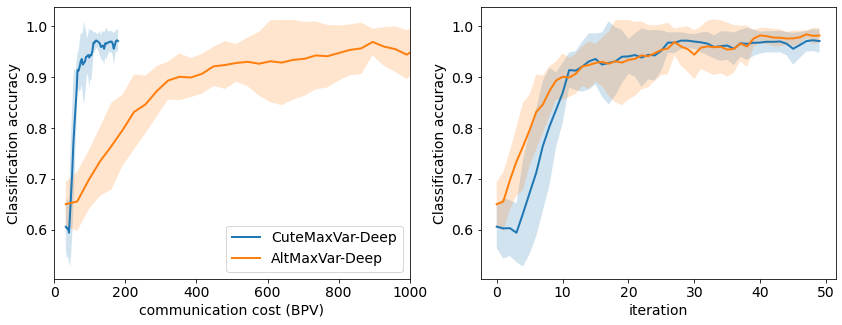

In [11]:
fig, axes = plt.subplots(1,2, figsize=(14,5))

comm_cute = np.arange(50)*3 + 32
comm_alt = np.arange(50)*32 + 32

cute_mean = acc['cute'].mean(axis=0)
alt_mean = acc['alt'].mean(axis=0)
cute_std = acc['cute'].std(axis=0)
alt_std = acc['alt'].std(axis=0)


axes[0].plot(comm_cute, acc['cute'].mean(axis=0), linewidth=2)
axes[0].fill_between(comm_cute, cute_mean+cute_std, cute_mean-cute_std, alpha=0.2)
axes[0].plot(comm_alt, acc['alt'].mean(axis=0), linewidth=2)
axes[0].fill_between(comm_alt, alt_mean+alt_std, alt_mean-alt_std, alpha=0.2)

axes[0].legend(['CuteMaxVar-Deep', 'AltMaxVar-Deep'], fontsize=14)
axes[0].set_xlabel('communication cost (BPV)', fontsize=14)
axes[0].set_ylabel('Classification accuracy', fontsize=14)
axes[0].set_xlim(0, 1000)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)


axes[1].plot(acc['cute'].mean(axis=0), linewidth=2)
axes[1].fill_between(np.arange(len(cute_mean)), cute_mean+cute_std, cute_mean-cute_std, alpha=0.2)
axes[1].plot(acc['alt'].mean(axis=0), linewidth=2)
axes[1].fill_between(np.arange(len(alt_mean)), alt_mean+alt_std, alt_mean-alt_std, alpha=0.2)

axes[1].set_xlabel('iteration', fontsize=14)
axes[1].set_ylabel('Classification accuracy', fontsize=14)

axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)


In [14]:
for i in range(len(alt_mean)):
    if alt_mean[i] >= 0.95:
        print(i)
        break
        
for i in range(len(cute_mean)):
    if cute_mean[i] >= 0.95:
        print(i)
        break

25
25


In [1]:
1 - 3/(32)

0.90625

In [12]:
fig.savefig('../plt/toy_class_acc.pdf')

Text(0, 0.5, 'objective value')

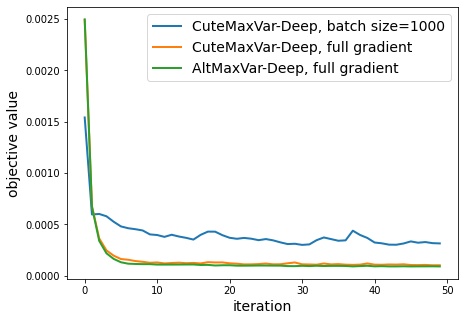

In [31]:
fig, axes = plt.subplots(1,1, figsize=(7,5))
axes.plot(df_cute['data_fidelity'], linewidth=2)
axes.plot(df_cute_full['data_fidelity'], linewidth=2)
axes.plot(df_alt['data_fidelity'], linewidth=2)
axes.legend(['CuteMaxVar-Deep, batch size=1000','CuteMaxVar-Deep, full gradient', 'AltMaxVar-Deep, full gradient'], fontsize=14)
axes.set_xlabel('iteration', fontsize=14)
axes.set_ylabel('objective value', fontsize=14)

In [32]:
fig.savefig('../plt/toy_training_obj.pdf')

In [15]:
df2

,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,0,0.001529,0.005274,1000,0.001,cpu
1,1,0.000480,0.005601,1000,0.001,cpu
2,2,0.000450,0.005553,1000,0.001,cpu
3,3,0.000398,0.005509,1000,0.001,cpu
4,4,0.000363,0.005514,1000,0.001,cpu
5,5,0.000365,0.005591,1000,0.001,cpu
6,6,0.000400,0.005617,1000,0.001,cpu
7,7,0.000357,0.005485,1000,0.001,cpu
8,8,0.000329,0.005477,1000,0.001,cpu
9,9,0.000335,0.005504,1000,0.001,cpu


In [46]:


# classification for distributed method
clf_dist = svm.LinearSVC()
clf_dist.fit(G_val[:-200,:].numpy(), val_classes[0][:-200].numpy())

accuracy_score(val_classes[0][:-200].numpy(), clf_dist.predict(G_val[:-200,:]))


LinearSVC()

In [44]:
G_val.shape

torch.Size([1000, 2])

## Plots mini batch GD

In [57]:
from dgcca.utils.clustering import *

dgcca_vanilla = torch.load('../trained_models/dgcca_toy_altmaxvar.model')
dgcca_dist = torch.load('../trained_models/dgcca_toy_cutemaxvar.model')

test_views, classes = create_synthData(N=1000)
test_views = [view.to(device) for view in test_views]


acc_raw = []

for view in test_views:
    acc_raw.append(get_clustering_acc(n_clusters=2, gamma=5, random_state=100, latent_repr=view, test_classes=classes[0]))

out1 = dgcca_vanilla(test_views)
out1 = [a.to('cpu').detach() for a in out1]


out1 = dgcca_vanilla(test_views)
G_vanilla = g_step(torch.stack(out1).clone().detach())
out1 = [a.to('cpu').detach() for a in out1]

out2 = dgcca_dist(test_views)
G_dist = g_step(torch.stack(out2).clone().detach())
out2 = [a.to('cpu').detach() for a in out2]

G_vanilla = G_vanilla.detach().to('cpu')
vanilla_cluster_acc = get_clustering_acc(n_clusters=2, gamma=5, random_state=100, latent_repr=G_vanilla, test_classes=classes[0])

G_dist = G_dist.detach().to('cpu')
dist_cluster_acc = get_clustering_acc(n_clusters=2, gamma=5, random_state=100, latent_repr=G_dist, test_classes=classes[0])

target = [t.to('cpu').detach() for t in test_views]



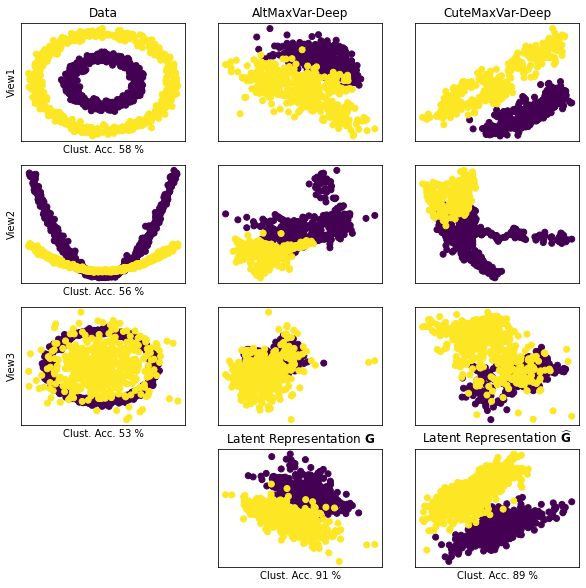

In [72]:
fig, axes = plt.subplots(4,3, figsize=(10,10))

axes[0,0].set_title('Data')
axes[0,0].scatter(target[0][:,0], target[0][:,1], c=500*[1]+500*[2])
axes[0,0].set_ylabel('View1')
axes[0,0].set_xlabel("Clust. Acc. " + str(int(acc_raw[0]*100)) +" %")

axes[1,0].scatter(target[1][:,0], target[1][:,1], c=500*[1]+500*[2])
axes[1,0].set_ylabel('View2')
axes[1,0].set_xlabel("Clust. Acc. " + str(int(acc_raw[1]*100)) +" %")

axes[2,0].scatter(target[2][:,0], target[2][:,1], c=500*[1]+500*[2])
axes[2,0].set_ylabel('View3')
axes[2,0].set_xlabel("Clust. Acc. " + str(int(acc_raw[2]*100)) +" %")


axes[0,1].set_title("AltMaxVar-Deep")
axes[0,1].scatter(out1[0][:,0], out1[0][:,1], c=500*[1]+500*[2])
axes[1,1].scatter(out1[1][:,0], out1[1][:,1], c=500*[1]+500*[2])
axes[2,1].scatter(out1[2][:,0], out1[2][:,1], c=500*[1]+500*[2])
axes[3,1].set_xlabel("Clust. Acc. " + str(int(vanilla_cluster_acc*100)) +" %")
axes[3,1].set_title('Latent Representation ' + r'${\mathbf{G}}$')
axes[3,1].scatter(G_vanilla[:,0], G_vanilla[:,1], c=500*[1]+500*[2])

axes[0,2].set_title("CuteMaxVar-Deep")
axes[0,2].scatter(out2[0][:,0], out2[0][:,1], c=500*[1]+500*[2])
axes[1,2].scatter(out2[1][:,0], out2[1][:,1], c=500*[1]+500*[2])
axes[2,2].scatter(out2[2][:,0], out2[2][:,1], c=500*[1]+500*[2])
axes[3,2].set_xlabel("Clust. Acc. " + str(int(dist_cluster_acc*100)) +" %")
axes[3,2].set_title('Latent Representation ' + r'$\widehat{\mathbf{G}}$')

axes[3,2].scatter(G_dist[:,0], G_dist[:,1], c=500*[1]+500*[2])

axes[3,0].axis('off')
for i in range(4):
    for j in range(3):
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])


In [73]:
fig.savefig('../plt/toy_scatter_plot.pdf')

In [43]:
vanilla_cluster_acc

0.89

In [44]:
acc_raw

[0.677, 0.558, 0.506]

In [59]:
fig.savefig('../plt/toy_dgcca_scatter.pdf')

In [43]:
from dgcca.utils.clustering import *

get_clustering_acc(n_clusters=2, gamma=5, random_state=100, latent_repr=G_dist, test_classes=classes[0])

0.561

In [53]:
99

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,

## Classification error

In [100]:
vanilla = torch.load('trained_models/dgcca_sgd_classifier.model')
fed = torch.load('trained_models/dgcca_fed_sgd_classifier.model')

train_views, train_classes = create_synthData(N=1000)

train_views = [view.to(device) for view in train_views]

# out1 = dgcca_vanilla(train_views)

out1 = dgcca_vanilla(train_views)
G1 = g_step(torch.stack(out1).clone().detach())
out1 = [a.type(torch.float32).detach() for a in out1]

out2 = dgcca_fed(train_views)
G2 = g_step(torch.stack(out2).clone().detach())
out2 = [a.type(torch.float32).detach() for a in out2]

vanilla_class = []
for i in range(3):
    a = vanilla.model_list[i](out1[i])
    vanilla_class.append((a.squeeze().round() - train_classes[i].to('cuda')).abs().sum())
    
a = vanilla.model_list[3](G1.type(torch.float32))
vanilla_class.append((a.squeeze().round() - train_classes[0].to('cuda')).abs().sum())


fed_class = []
for i in range(3):
    a = fed.model_list[i](out2[i])
    fed_class.append((a.squeeze().round() - train_classes[i].to('cuda')).abs().sum())
    
a = fed.model_list[3](G2.type(torch.float32))
fed_class.append((a.squeeze().round() - train_classes[0].to('cuda')).abs().sum())

In [101]:
fed_class

[tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(44., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(78., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(1., device='cuda:0', grad_fn=<SumBackward0>)]

In [102]:
vanilla_class

[tensor(0., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(41., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(85., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0., device='cuda:0', grad_fn=<SumBackward0>)]

In [107]:
[1-i/1000 for i in fed_class]

[tensor(1., device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9560, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9220, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9990, device='cuda:0', grad_fn=<RsubBackward1>)]

In [108]:
[1-i/1000 for i in vanilla_class]

[tensor(1., device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9590, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.9150, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(1., device='cuda:0', grad_fn=<RsubBackward1>)]

In [78]:
a = classifier.model_list[1](out1[1])
(a.squeeze().round() - train_classes[1].to('cuda'))

tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  

In [75]:
train_classes[0].shape

torch.Size([1000])

In [76]:
a.shape

torch.Size([1000, 1])

In [65]:
train_classes

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,

## Plot the curves

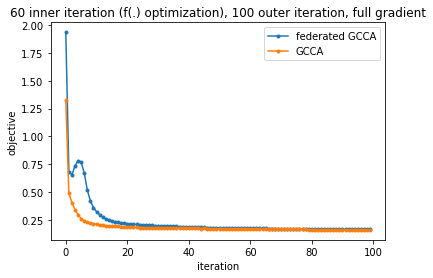

In [23]:
# fig, axes = plt.subplots(1,2, figsize=(10,10))
# plt.figsize=(20, 20)

plt.plot(df3['data_fidelity'], marker='.')
plt.plot(df2['data_fidelity'], marker='.')
plt.legend(['federated GCCA', 'GCCA'])
plt.xlabel('iteration')
plt.ylabel('objective')
plt.title('60 inner iteration (f(.) optimization), 100 outer iteration, full gradient')

plt.savefig('plt/convergence.pdf')

In [17]:
1000/16

62.5

## DGCCA

In [45]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, DeepGCCA
from synth_data import create_synthData

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    inner_epochs = [10]
)

layer_sizes_list = 3*[[128, 64, 2]]
input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = DeepGCCA(layer_sizes_list, input_size_list)
    dgcca = dgcca.to(device)
    
    train_views, classes = create_synthData(N=10000)
    val_views, classes = create_synthData(N=200)
    
    train_views = [view.to(device) for view in train_views]
    val_views = [view.to(device) for view in val_views]
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()
    num_val_batches = len(val_views[0])//run.batch_size
    

    
    for epoch in range(50):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_recons_loss/num_batches
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device

        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        
        ## initialize G
        dgcca.eval()
        out = dgcca(train_views)
        out = torch.stack(out)  
        G = g_step(out.clone().detach())
        
        dgcca.train()
        for j in range(run.inner_epochs):
            for i in range(num_batches):
                optimizer.zero_grad()
                batch = []
                
                # SGD
#                 batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :] for view in train_views]            
#                 target = G[(i*run.batch_size):((i+1)*run.batch_size), :]

                # full gradient
                batch = train_views
                target = G

                out = dgcca(batch)
                out = torch.stack(out)  
                
                loss = 1/2*torch.norm(out-target)/target.shape[0]
                
#                 print(loss.item())
                
                loss.backward()
                optimizer.step()
                
                total_recons_loss += loss.item()
                
        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        G_val = g_step(out_val.clone().detach())
        loss_val = 1/2*torch.norm(out_val - G_val)/G_val.shape[0]
        total_val_loss += loss_val.item()

        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/(num_batches*run.inner_epochs)
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df2)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(dgcca, 'trained_models/dgcca_full.model')

,run_count,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,1,0,0.000442,0.005316,1000,0.001,cuda
1,1,1,0.000090,0.005247,1000,0.001,cuda
2,1,2,0.000079,0.005167,1000,0.001,cuda
3,1,3,0.000072,0.005197,1000,0.001,cuda
4,1,4,0.000066,0.005140,1000,0.001,cuda
5,1,5,0.000061,0.005161,1000,0.001,cuda
6,1,6,0.000057,0.005139,1000,0.001,cuda
7,1,7,0.000055,0.005148,1000,0.001,cuda
8,1,8,0.000054,0.005162,1000,0.001,cuda
9,1,9,0.000053,0.005150,1000,0.001,cuda


## SGD

In [1]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, DeepGCCA
from synth_data import create_synthData

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    inner_epochs = [50],
    quant = [True]
)

layer_sizes_list = 3*[[128, 64, 2]]
input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = DeepGCCA(layer_sizes_list, input_size_list)
    dgcca = dgcca.to(device)
    
    train_views, classes = create_synthData(N=10000)
    val_views, classes = create_synthData(N=200)
    suffler = torch.randperm(10000)
    
    train_views = [view[suffler].to(device) for view in train_views]
    val_views = [view.to(device) for view in val_views]
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()
    num_val_batches = len(val_views[0])//run.batch_size
    
    # init G
    dgcca.eval()
    out = dgcca(train_views)
    out = torch.stack(out)  
    G = g_step(out.clone().detach())  
    M_serv = out.clone()
    M_diff = out.clone()
    dgcca.train()
    
    for epoch in range(50):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_recons_loss/num_batches
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device

        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        
        for j in range(run.inner_epochs):
            for i in range(num_batches):
                optimizer.zero_grad()
                batch = []
                
                # SGD
                batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :] for view in train_views]            
                target = G[(i*run.batch_size):((i+1)*run.batch_size), :]

                # full gradient
#                 batch = train_views
#                 target = G

                out = dgcca(batch)
                out = torch.stack(out)  
                
                loss = 1/2*torch.norm(out-target)/target.shape[0]
                
#                 print(loss.item())
                
                loss.backward()
                optimizer.step()
                
                total_recons_loss += loss.item()
                
        ## Update G
        dgcca.eval()
        out = dgcca(train_views)
        out = torch.stack(out)
        
        if run.quant:
            for i in range(len(train_views)):
                M_diff[i] = out[i] - M_serv[i]
                max_val = M_diff[i].abs().max()
                M_quant = ((1/max_val)*M_diff[i]).round()*(max_val/1)
                M_serv[i] += M_quant
            G = g_step(M_serv.clone().detach())          
        else:
            G = g_step(out.clone().detach())  
            
        
        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        G_val = g_step(out_val.clone().detach())
        loss_val = 1/2*torch.norm(out_val - G_val)/G_val.shape[0]
        total_val_loss = loss_val.item()

        dgcca.train()
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/(num_batches*run.inner_epochs)
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df2)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(dgcca, 'trained_models/dgcca_federated_sgd2.model')

,run_count,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,1,0,0.000682,0.005485,1000,0.001,cuda
1,1,1,0.000395,0.005731,1000,0.001,cuda
2,1,2,0.000366,0.005610,1000,0.001,cuda


KeyboardInterrupt: 

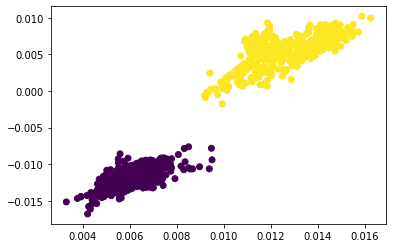

In [56]:
train_views, classes = create_synthData(N=1000)
val_views, classes = create_synthData(N=200)

train_views = [view.to(device) for view in train_views]
val_views = [view.to(device) for view in val_views]
out = dgcca(train_views)
out = [a.to('cpu').detach() for a in out]

plt.scatter(out[0][:,0], out[0][:,1], c=500*[1]+500*[2])

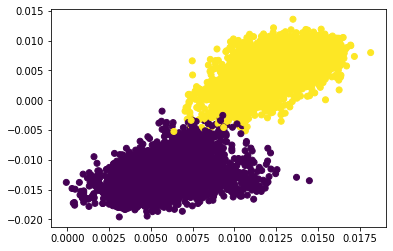

In [57]:
G = G.to('cpu').detach()
classes = 5000*[1]+5000*[2]
# classes = classes[list(suffler.numpy())]
suffled_c = [classes[i] for i in list(suffler) ]
plt.scatter(G[:,0], G[:,1], c=suffled_c)

## Classifier DGCCA

In [60]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, DeepGCCA, DGCCAClassifierToy
from synth_data import create_synthData
import numpy as np

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.BCELoss],
    num_views = [4]
)

layer_sizes_list = 3*[[128, 64, 2]]
input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):

    run_count += 1
    device = torch.device(run.device)
    
    classifier = DGCCAClassifierToy(num_views=run.num_views)
    classifier.to(device)
    dgcca = torch.load('trained_models/dgcca_federated_sgd1.model')
    dgcca.eval()
    
    train_views, train_classes = create_synthData(N=10000)
    val_views, val_classes = create_synthData(N=200)
    suffler = torch.randperm(10000)
    
    train_classes.append(train_classes[0])
    val_classes.append(val_classes[0])
    
    
    train_classes = [view[suffler].to(device).unsqueeze(dim=1) for view in train_classes]
    val_classes = [view.to(device).unsqueeze(dim=1) for view in val_classes]
    
    train_views = [view[suffler].to(device) for view in train_views]
    val_views = [view.to(device) for view in val_views]
    
    train_out = dgcca(train_views)
    train_G = g_step(torch.stack(train_out).clone().detach().type(torch.float32))

    val_out = dgcca(val_views)
    val_G = g_step(torch.stack(val_out).clone().detach().type(torch.float32))
   
    train_out = [view.detach().clone().type(torch.float32) for view in train_out]
    train_out.append(train_G)
    val_out = [view.type(torch.float32) for view in val_out]
    val_out.append(val_G)
    
    optimizer = torch.optim.Adam(classifier.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()
    num_val_batches = len(val_views[0])//run.batch_size
    
    for epoch in range(500):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_recons_loss/num_batches
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device

        df = pd.DataFrame.from_dict(run_data, orient='columns')
        
        for i in range(num_batches):
            optimizer.zero_grad()
            batch = []

            # SGD
            batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :] for view in train_out]            
            target = [view[(i*run.batch_size):((i+1)*run.batch_size)] for view in train_classes] 

            out = classifier(batch)

            loss = classifier.loss_backward(out, target)
            optimizer.step()

            total_recons_loss += np.array(loss).mean()

        # validation loss
        out_val = classifier(val_out)
        loss = criterion(torch.stack(out_val), torch.stack(val_classes))
        total_val_loss = loss.item()

        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/(num_batches)
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        df = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(classifier, 'trained_models/dgcca_fed_sgd_classifier.model')

,run_count,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,1,0,0.486031,0.294981,1000,0.001,cuda
1,1,1,0.236538,0.206504,1000,0.001,cuda
2,1,2,0.180581,0.168944,1000,0.001,cuda
3,1,3,0.152388,0.150434,1000,0.001,cuda
4,1,4,0.137654,0.139176,1000,0.001,cuda
...,...,...,...,...,...,...,...
495,1,495,0.074978,0.087942,1000,0.001,cuda
496,1,496,0.074912,0.087764,1000,0.001,cuda
497,1,497,0.075006,0.088805,1000,0.001,cuda
498,1,498,0.074974,0.088191,1000,0.001,cuda


In [50]:
a = classifier.model_list[0](val_out[0])

b = (a.round() - val_classes[0])

b.abs().sum()

In [42]:
import numpy as np
np.array(a).mean()

2.6666666666666665

In [40]:
import math

math.mean(a)

AttributeError: module 'math' has no attribute 'mean'

## Federated DGCCA for toy 2D example

In [2]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step
class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [16],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss]
)

layer_sizes_list = 3*[[128, 64, 2]]
input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = DeepGCCA(layer_sizes_list, input_size_list)
    dgcca = dgcca.to(device)
    
    train_views, classes = create_synthData(N=1000)
    val_views, classes = create_synthData(N=200)
    
    train_views = [view.to(device) for view in train_views]
    val_views = [view.to(device) for view in val_views]
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()
    num_val_batches = len(val_views[0])//run.batch_size
    
    out = dgcca(train_views)
    out = torch.stack(out)  
    G = g_step(out.clone().detach())  
    M_serv = out.clone()
    M_diff = out.clone()
    
    I = len(train_views)
    
    for epoch in range(100):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_recons_loss/num_batches
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device

        df3 = pd.DataFrame.from_dict(run_data, orient='columns')
        
        for i in range(num_batches):
            optimizer.zero_grad()
            batch = []
            batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :] for view in train_views]            
            target = G[(i*run.batch_size):((i+1)*run.batch_size), :]
            
            # full gradient
            batch = train_views
            target = G
            
            out = dgcca(batch)
            out = torch.stack(out)  
            # G = g_step(out.clone().detach())
            loss = 1/3*torch.norm(out-target)
            loss.backward()
            optimizer.step()
            total_recons_loss += loss.item()
            
        ## initialize G
        out = dgcca(train_views)
        out = torch.stack(out)
        
        for i in range(I):
            M_diff[i] = out[i] - M_serv[i]
            max_val = M_diff[i].abs().max()
            M_quant = ((1/max_val)*M_diff[i]).round()*(max_val/1)
            M_serv[i] += M_quant
        G = g_step(M_serv.clone().detach())    
        
        
        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        G_val = g_step(out_val.clone().detach())
        loss_val = criterion(out_val, G_val)
        total_val_loss += loss_val.item()

        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        df3 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df3)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(dgcca, 'trained_models/dgcca_federated1.model')

,run_count,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,1,0,1.936397,0.003102,16,0.001,cuda
1,1,1,0.682871,0.003156,16,0.001,cuda
2,1,2,0.653893,0.002993,16,0.001,cuda
3,1,3,0.733880,0.003569,16,0.001,cuda
4,1,4,0.781140,0.003783,16,0.001,cuda
...,...,...,...,...,...,...,...
95,1,95,0.162442,0.001911,16,0.001,cuda
96,1,96,0.162157,0.001908,16,0.001,cuda
97,1,97,0.162470,0.001890,16,0.001,cuda
98,1,98,0.162947,0.001922,16,0.001,cuda


,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,0,0.000599,0.005269,10000,0.001,cpu
1,1,0.000119,0.005703,10000,0.001,cpu
2,2,0.000104,0.005729,10000,0.001,cpu
3,3,0.000098,0.005619,10000,0.001,cpu
4,4,0.000093,0.005621,10000,0.001,cpu
5,5,0.000091,0.005600,10000,0.001,cpu
6,6,0.000090,0.005632,10000,0.001,cpu
7,7,0.000090,0.005564,10000,0.001,cpu
8,8,0.000088,0.005559,10000,0.001,cpu
9,9,0.000087,0.005606,10000,0.001,cpu


KeyboardInterrupt: 

In [1]:
a = DeepGCCA(layer_sizes_list, input_size_list)
a = a.to('cuda')

NameError: name 'DeepGCCA' is not defined

In [8]:
b = DeepGCCA(layer_sizes_list, input_size_list)

In [10]:
b.load_state_dict(a.state_dict())

<All keys matched successfully>

In [3]:
a = [5]*10


In [12]:
a[6:]

[5, 5, 5, 5]